In [1]:
import pytz
import os
import sqlite3
import re
import uproot
import IPython
import sys
import copy
import numpy as np
import pandas as pd
import pymap3d as pm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pandasql import sqldf
from rnog_data.runtable import RunTable
from datetime import datetime, timedelta
from scipy.fft import fft
from scipy.signal import stft
from NuRadioReco.modules.io.RNO_G.readRNOGDataMattak import readRNOGData
from NuRadioReco.utilities import units
from Flight import Flight
from IPython.display import clear_output


pd.options.display.float_format = '{:20,.15f}'.format
#-------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------
from FlightTracker import FlightTracker

current_month = '04'
next_month = '06'

start_time=f'2023-{current_month}-01 00:00:00'
stop_time=f'2023-{next_month}-01 00:00:00'

#start_time=f'2023-01-01 00:00:00'
#stop_time=f'2024-01-01 00:00:00'

tracker_initial = FlightTracker(start_time, stop_time, destination='./flights/flights_2023.db', already_calculated=True)
tracker = copy.deepcopy(tracker_initial) # make a new instance of the tracker
print(len(tracker.flights), len(tracker.flights_distinct))
tracker.flights_distinct

172826 1002


,index,flightnumber,date,filename,mintime,maxtime,min_r,min_z,theta
0,3261,DLH9922,2023-04-01,2023.04.01-051111.db,2023-04-01 00:42:32.100000,2023-04-01 01:01:07.500000,33.100000000000001,10.800000000000001,15.000000000000000
1,3262,N/A,2023-04-01,2023.04.01-051111.db,2023-04-01 00:59:37.100000,2023-04-01 03:40:13.900000,99.900000000000006,7.800000000000000,52.000000000000000
2,3263,N/A,2023-04-01,2023.04.01-051111.db,2023-04-01 05:21:28.400000,2023-04-01 18:48:53.900000,89.900000000000006,7.200000000000000,57.000000000000000
3,3264,CSN312,2023-04-01,2023.04.01-051111.db,2023-04-01 02:49:29.100000,2023-04-01 03:05:38.800000,72.799999999999997,7.700000000000000,49.000000000000000
4,3265,DLH491,2023-04-01,2023.04.01-051111.db,2023-04-01 03:20:48.200000,2023-04-01 03:40:39.000000,32.899999999999999,10.100000000000000,15.000000000000000
...,...,...,...,...,...,...,...,...,...
997,1703,AIC103,2023-05-31,2023.06.01-051619.db,2023-05-31 05:26:06.200000,2023-05-31 05:38:04.700000,122.799999999999997,10.400000000000000,54.000000000000000
998,1704,N/A,2023-05-31,2023.06.01-051619.db,2023-05-31 05:28:47.000000,2023-05-31 09:46:47.300000,77.200000000000003,8.800000000000001,67.000000000000000
999,1705,QTR65R,2023-05-31,2023.06.01-051619.db,2023-05-31 05:39:35.100000,2023-05-31 05:54:49.600000,72.299999999999997,8.300000000000001,6.000000000000000
1000,1706,UAE41P,2023-05-31,2023.06.01-051619.db,2023-05-31 06:37:17.000000,2023-05-31 06:52:21.400000,72.400000000000006,8.900000000000000,6.000000000000000


In [2]:
'''con = sqlite3.connect('./header_files_for_time_range/header_2023')

temp_df = pd.read_sql_query(f'Select * from all_triggers_2023_04 where lt_triggers = 1', con)

con.close()
print(len(temp_df))'''

temp_df = pd.DataFrame()
con = sqlite3.connect('./header_files_for_time_range/header_2023')
for table in ['all_triggers_2023_04', 'all_triggers_2023_05']:
    temp = pd.read_sql_query(f'Select * From {table} where radiant_triggers = 1', con)
    if(len(temp_df == 0)):
        temp_df = temp
    else:
        temp_df = pd.concat([temp_df, temp], ignore_index=True, sort=False)
con.close()
temp_df

,index,station_number,run_number,event_number,trigger_time,radiant_triggers,lt_triggers,force_triggers
0,0,11,2084,7422,"1,682,928,352.212568283081055",1,0,0
1,2,11,2084,7424,"1,682,928,352.545515298843384",1,0,0
2,3,11,2084,7425,"1,682,928,353.990741968154907",1,0,0
3,4,11,2084,7426,"1,682,928,354.940427780151367",1,0,0
4,6,11,2084,7428,"1,682,928,358.051073312759399",1,0,0
...,...,...,...,...,...,...,...,...
3098662,9112722,24,1397,802,"1,685,526,753.152338504791260",1,0,0
3098663,9112730,24,1397,810,"1,685,526,770.078838586807251",1,0,0
3098664,9112731,24,1397,811,"1,685,526,770.250617027282715",1,0,0
3098665,9112743,24,1397,823,"1,685,526,785.359153985977173",1,0,0


In [3]:
# add fk_date_flightnumber
flights_distinct = tracker.flights_distinct
flights_distinct = sqldf(''' 
SELECT
    *
    ,date || '_' || flightnumber as fk_date_flightnumber
FROM flights_distinct
''')
flights = tracker.flights
flights = sqldf(''' 
SELECT
    *
    ,date(readtime) || '_' || flightnumber as fk_date_flightnumber
FROM flights
''')


flights_distinct['mintime'] = pd.to_datetime(flights_distinct.mintime).dt.tz_localize('UTC')
flights_distinct['maxtime'] = pd.to_datetime(flights_distinct.maxtime).dt.tz_localize('UTC')

flights_distinct['mintime_millis'] = flights_distinct.mintime.astype(np.int64) // 10 ** 6
flights_distinct['maxtime_millis'] = flights_distinct.maxtime.astype(np.int64) // 10 ** 6

flights_distinct['mintime_sec'] = flights_distinct.mintime.astype(np.int64) // 10 ** 9
flights_distinct['maxtime_sec'] = flights_distinct.maxtime.astype(np.int64) // 10 ** 9

flights_distinct['ID'] = flights_distinct.index

temp_df['trigger_time_millis'] = (temp_df['trigger_time'] * (10 ** 3)).astype(np.int64)
temp_df['trigger_time_sec'] = (temp_df['trigger_time']).astype(np.int64)

flights_distinct

,index,flightnumber,date,filename,mintime,maxtime,min_r,min_z,theta,fk_date_flightnumber,mintime_millis,maxtime_millis,mintime_sec,maxtime_sec,ID
0,3261,DLH9922,2023-04-01,2023.04.01-051111.db,2023-04-01 00:42:32.100000+00:00,2023-04-01 01:01:07.500000+00:00,33.100000000000001,10.800000000000001,15.000000000000000,2023-04-01_DLH9922,1680309752100,1680310867500,1680309752,1680310867,0
1,3262,N/A,2023-04-01,2023.04.01-051111.db,2023-04-01 00:59:37.100000+00:00,2023-04-01 03:40:13.900000+00:00,99.900000000000006,7.800000000000000,52.000000000000000,2023-04-01_N/A,1680310777100,1680320413900,1680310777,1680320413,1
2,3263,N/A,2023-04-01,2023.04.01-051111.db,2023-04-01 05:21:28.400000+00:00,2023-04-01 18:48:53.900000+00:00,89.900000000000006,7.200000000000000,57.000000000000000,2023-04-01_N/A,1680326488400,1680374933900,1680326488,1680374933,2
3,3264,CSN312,2023-04-01,2023.04.01-051111.db,2023-04-01 02:49:29.100000+00:00,2023-04-01 03:05:38.800000+00:00,72.799999999999997,7.700000000000000,49.000000000000000,2023-04-01_CSN312,1680317369100,1680318338800,1680317369,1680318338,3
4,3265,DLH491,2023-04-01,2023.04.01-051111.db,2023-04-01 03:20:48.200000+00:00,2023-04-01 03:40:39+00:00,32.899999999999999,10.100000000000000,15.000000000000000,2023-04-01_DLH491,1680319248200,1680320439000,1680319248,1680320439,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,1703,AIC103,2023-05-31,2023.06.01-051619.db,2023-05-31 05:26:06.200000+00:00,2023-05-31 05:38:04.700000+00:00,122.799999999999997,10.400000000000000,54.000000000000000,2023-05-31_AIC103,1685510766200,1685511484700,1685510766,1685511484,997
998,1704,N/A,2023-05-31,2023.06.01-051619.db,2023-05-31 05:28:47+00:00,2023-05-31 09:46:47.300000+00:00,77.200000000000003,8.800000000000001,67.000000000000000,2023-05-31_N/A,1685510927000,1685526407300,1685510927,1685526407,998
999,1705,QTR65R,2023-05-31,2023.06.01-051619.db,2023-05-31 05:39:35.100000+00:00,2023-05-31 05:54:49.600000+00:00,72.299999999999997,8.300000000000001,6.000000000000000,2023-05-31_QTR65R,1685511575100,1685512489600,1685511575,1685512489,999
1000,1706,UAE41P,2023-05-31,2023.06.01-051619.db,2023-05-31 06:37:17+00:00,2023-05-31 06:52:21.400000+00:00,72.400000000000006,8.900000000000000,6.000000000000000,2023-05-31_UAE41P,1685515037000,1685515941400,1685515037,1685515941,1000


In [4]:
fk_timestamp = pd.DataFrame(columns = ['trigger_time_sec'], data = range(flights_distinct.mintime_millis.min() // 1000, flights_distinct.maxtime_millis.max() // 1000, 1))
fk_timestamp

,trigger_time_sec
0,1680309752
1,1680309753
2,1680309754
3,1680309755
4,1680309756
...,...
5217047,1685526799
5217048,1685526800
5217049,1685526801
5217050,1685526802


In [5]:
query = ''' 
SELECT
    count(trigger_time_sec) as sum_triggers_per_second
    --,station_number
    ,trigger_time_sec
    --,CASE 
    --    WHEN force_triggers = 1 THEN 1
    --    WHEN lt_triggers = 1 THEN 2
    --    WHEN radiant_triggers = 1 THEN 3
    --    ELSE -1
    --END AS trigger_type
    --,force_triggers
    --,lt_triggers
    --,radiant_triggers
    --,trigger_time_millis
FROM temp_df
--GROUP BY station_number, trigger_time_sec

GROUP BY trigger_time_sec
'''

test = sqldf(query)
test

,sum_triggers_per_second,trigger_time_sec
0,2,1682928352
1,1,1682928353
2,2,1682928354
3,4,1682928358
4,3,1682928359
...,...,...
738717,1,1685526794
738718,3,1685526796
738719,1,1685526800
738720,1,1685526802


In [6]:
fk_timestamp = fk_timestamp.merge(test, on=['trigger_time_sec'], how='left')

In [7]:
fk_timestamp

,trigger_time_sec,sum_triggers_per_second
0,1680309752,NaN
1,1680309753,NaN
2,1680309754,NaN
3,1680309755,NaN
4,1680309756,NaN
...,...,...
5217047,1685526799,NaN
5217048,1685526800,1.000000000000000
5217049,1685526801,NaN
5217050,1685526802,1.000000000000000


In [8]:
fk_timestamp.sum_triggers_per_second.fillna(0, inplace = True)
#fk_timestamp.station_number.fillna(-1, inplace=True)
#fk_timestamp.force_triggers.fillna(-1, inplace=True)

In [9]:
fk_timestamp

,trigger_time_sec,sum_triggers_per_second
0,1680309752,0.000000000000000
1,1680309753,0.000000000000000
2,1680309754,0.000000000000000
3,1680309755,0.000000000000000
4,1680309756,0.000000000000000
...,...,...
5217047,1685526799,0.000000000000000
5217048,1685526800,1.000000000000000
5217049,1685526801,0.000000000000000
5217050,1685526802,1.000000000000000


In [10]:
fk_timestamp['sum_triggers_per_second'] = fk_timestamp.sum_triggers_per_second.astype('uint16')

In [11]:
# join header information on flights_distinct
query = '''
SELECT 
    flightnumber
    ,fk_date_flightnumber
    --,station_number
    ,sum_triggers_per_second
    ,trigger_time_sec
FROM flights_distinct
LEFT JOIN ( 
            SELECT
                *
            FROM fk_timestamp
)t0

ON t0.trigger_time_sec > flights_distinct.mintime_sec
AND t0.trigger_time_sec < flights_distinct.maxtime_sec
WHERE trigger_time_sec is not null
and min_r < 50
--AND force_triggers = 0
--AND lt_triggers = 1
--AND radiant_triggers = 1
--GROUP BY fk_date_flightnumber, station_number, trigger_time_sec
GROUP BY fk_date_flightnumber, trigger_time_sec
'''

result = sqldf(query)
clear_output(wait=True)
result

,flightnumber,fk_date_flightnumber,sum_triggers_per_second,trigger_time_sec
0,CPA095,2023-04-01_CPA095,0,1680338251
1,CPA095,2023-04-01_CPA095,0,1680338252
2,CPA095,2023-04-01_CPA095,0,1680338253
3,CPA095,2023-04-01_CPA095,0,1680338254
4,CPA095,2023-04-01_CPA095,0,1680338255
...,...,...,...,...
839345,UAE93Q,2023-05-31_UAE93Q,0,1685511213
839346,UAE93Q,2023-05-31_UAE93Q,0,1685511214
839347,UAE93Q,2023-05-31_UAE93Q,0,1685511215
839348,UAE93Q,2023-05-31_UAE93Q,3,1685511216


In [12]:
#-------------------------------------------------------------------------------------------------------------------
def part_lin(x, times, r):
    return_linspace = []
    for element in x:
        #print()
        #print(times, element)
        #print(np.where(times <= element))
        #print()
        index = np.where(times <= element)[0][-1]
        if index >= (len(times) - 1):
            index = index - 1
            print(f'Index {index} out of range {len(times) - 1}')
        y2 = r.iloc[index+1]
        y1 = r.iloc[index]
        x2 = times.iloc[index+1]
        x1 = times.iloc[index]
        m = (y2 - y1) / (x2 - x1)
        t = y2 - m * x2
        return_linspace.append(m*element+t)
    len_ret = len(return_linspace)
    len_x = len(x)
    while(len_ret < len_x):
        return_linspace.append(0)

    return return_linspace

In [13]:
result_df = pd.DataFrame()
length = len(flights_distinct)

for i in range(length):
    clear_output(wait=True)
    #----------------------------------------------------------
    fk_date_flightnumber = flights_distinct.fk_date_flightnumber.iloc[i]
    print(fk_date_flightnumber, ', ', i, ':', length)

    #----------------------------------------------------------   
    flights_temp = flights[flights.fk_date_flightnumber == fk_date_flightnumber]
    
    times = pd.to_datetime(flights_temp.readtime_utc, format='ISO8601').astype('int64') / 10**9
    r = np.sqrt(flights_temp.r2)
    trigger_times = result[result.fk_date_flightnumber == fk_date_flightnumber].trigger_time_sec

    if((len(trigger_times) == 0) | len(times) == 0):
        print('len trigger_times = 0 or flightnunber == N/A or len(times) == 0')
        continue
    
    temp_table = pd.DataFrame(result[result.fk_date_flightnumber == fk_date_flightnumber].copy())
    print(f'flightnumber: {fk_date_flightnumber}')

    #print('--------------------------------------------')
    #print(times.min(), '<', trigger_times.min())
    #print(trigger_times.max(), '<', times.max())
    #print('--------------------------------------------')

    temp_table['d'] = part_lin(trigger_times, times, r)
    if(len(temp_table)):
        result_df = pd.concat([result_df, temp_table], ignore_index=True, sort=False)

result_df = result_df[~result_df['flightnumber'].str.contains('SKI', na=False)]
result_df


2023-05-31_AIC187   ,  1001 : 1002
flightnumber: 2023-05-31_AIC187  


,flightnumber,fk_date_flightnumber,sum_triggers_per_second,trigger_time_sec,d
0,DLH9922,2023-04-01_DLH9922,0,1680309753,149.482938468456268
1,DLH9922,2023-04-01_DLH9922,0,1680309754,149.234492778778076
2,DLH9922,2023-04-01_DLH9922,0,1680309755,148.986047148704529
3,DLH9922,2023-04-01_DLH9922,0,1680309756,148.737601459026337
4,DLH9922,2023-04-01_DLH9922,0,1680309757,148.489155769348145
...,...,...,...,...,...
1278251,UAE93Q,2023-05-31_UAE93Q,0,1685511213,143.552009858635415
1278252,UAE93Q,2023-05-31_UAE93Q,0,1685511214,143.552009858635415
1278253,UAE93Q,2023-05-31_UAE93Q,0,1685511215,143.552009858635415
1278254,UAE93Q,2023-05-31_UAE93Q,3,1685511216,143.552009858635415


Text(0, 0.5, 'avg trigger rate')

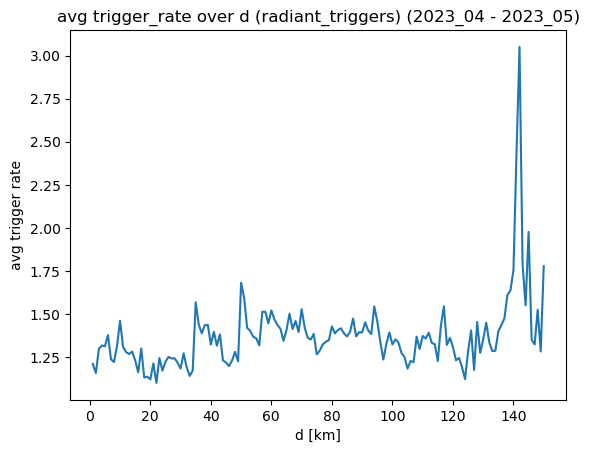

In [18]:
test = sqldf('Select avg(sum_triggers_per_second) as avg_triggers_per_sec, round(d, 0) as d from result_df group by round(d, 0)')
plt.plot(test.d, test.avg_triggers_per_sec)
plt.title('avg trigger_rate over d (radiant_triggers) (2023_04 - 2023_05)')
plt.xlabel('d [km]')
plt.ylabel('avg trigger rate')

Text(0, 0.5, '# triggers [Hz]')

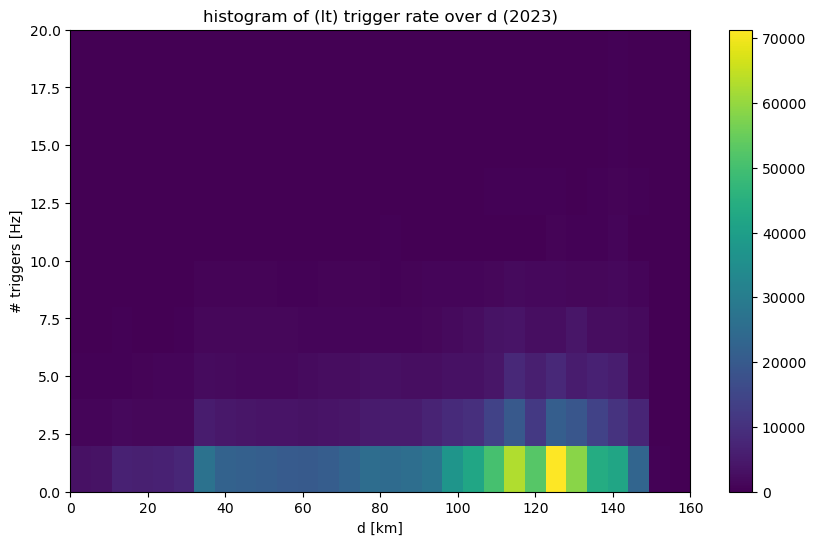

In [15]:
from matplotlib.colors import LogNorm
#result_df = result_df[~result_df['flightnumber'].str.contains('SKI', na=False)]
#max_index = result_df['triggers_per_second'].idxmax()

plt.figure(figsize=(10, 6))
# Get the flightnumber at this index
#max_flightnumber = result_df.at[max_index, 'flightnumber']
#print(max_flightnumber)
#h, xedges, yedges, image = plt.hist2d(result_df.d, result_df.triggers_per_second, range = [[0, 160], [0, 15]], bins = [100, 10])
h, xedges, yedges, image = plt.hist2d(result_df.d, result_df.sum_triggers_per_second, range = [[0, 160], [0,20]], bins = [30, 10])#, range = [[0, 160], [0, 15]], bins = [100, 15])#, norm = LogNorm())
plt.colorbar()
#plt.semilogy()
plt.title('histogram of (lt) trigger rate over d (2023)')
plt.xlabel('d [km]')
plt.ylabel(f'# triggers [Hz]')
#plt.savefig('./saved_figures/hist2d_lt_triggers_per_sec_over_d_2023.pdf')

Text(0, 0.5, '# counts')

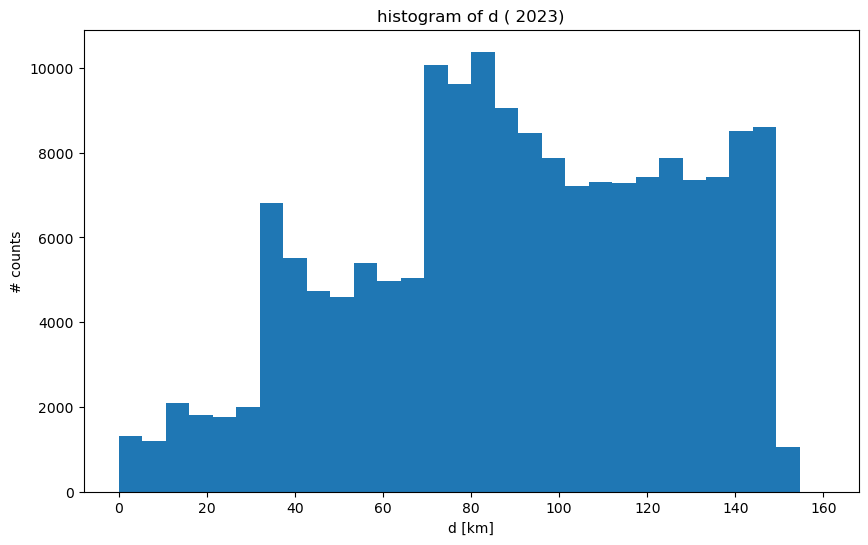

In [16]:
plt.figure(figsize=(10, 6))
a = plt.hist(np.sqrt(flights.r2), bins = xedges)

plt.title('histogram of d ( 2023)')
plt.xlabel('d [km]')
plt.ylabel(f'# counts')
#plt.savefig('./saved_figures/hist_d_2023.pdf')

/tmp/ipykernel_9425/2947665761.py:2: RuntimeWarning: invalid value encountered in divide
  plt.pcolormesh(xedges, yedges, h.T/a[0])


Text(0, 0.5, '# triggers [Hz]')

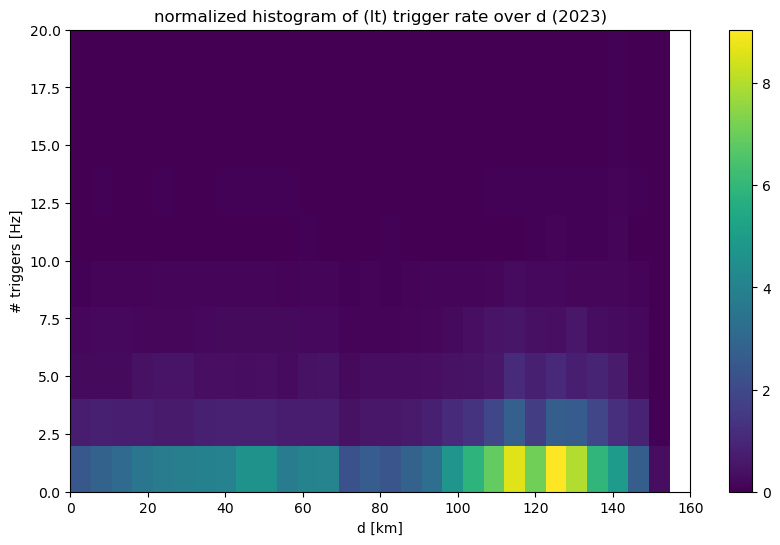

In [17]:
plt.figure(figsize=(10, 6))
plt.pcolormesh(xedges, yedges, h.T/a[0])
plt.colorbar()
plt.title('normalized histogram of (lt) trigger rate over d (2023)')
plt.xlabel('d [km]')
plt.ylabel(f'# triggers [Hz]')
#plt.savefig('./saved_figures/hist2d_lt_triggers_per_sec_over_d_NORMALIZED_2023_0.pdf')

In [4]:
from FlightTracker import FlightTracker
start_time='2023-05-12 00:00:00'
stop_time='2023-05-13 00:00:00'
test = FlightTracker(start_time, stop_time)
test.flights_distinct

,index,flightnumber,date,filename,mintime,maxtime,min_r,min_z,theta
0,0,THY8JK,2023-05-12,2023.05.13-051443.db,2023-05-12 06:58:57.800000,2023-05-12 07:16:48.000000,29.2,9.5,15.0
1,1,N/A,2023-05-12,2023.05.13-051443.db,2023-05-12 07:16:53.100000,2023-05-12 18:15:20.100000,82.3,4.9,31.0
2,2,THY8MT,2023-05-12,2023.05.13-051443.db,2023-05-12 11:09:10.800000,2023-05-12 11:25:05.500000,32.9,8.6,15.0
3,3,THY73G,2023-05-12,2023.05.13-051443.db,2023-05-12 11:13:57.200000,2023-05-12 11:31:27.300000,32.9,10.2,15.0
4,4,SAS931,2023-05-12,2023.05.13-051443.db,2023-05-12 11:15:07.600000,2023-05-12 11:31:52.400000,70.7,9.8,10.0
5,5,OCN72,2023-05-12,2023.05.13-051443.db,2023-05-12 12:36:11.200000,2023-05-12 12:52:41.000000,32.6,9.2,15.0
6,6,DLH456,2023-05-12,2023.05.13-051443.db,2023-05-12 13:01:23.500000,2023-05-12 13:18:28.500000,72.4,8.9,10.0
7,7,DAL179,2023-05-12,2023.05.13-051443.db,2023-05-12 13:14:57.500000,2023-05-12 13:31:02.200000,82.5,9.6,25.0
8,8,DLH490,2023-05-12,2023.05.13-051443.db,2023-05-12 13:32:22.600000,2023-05-12 13:50:27.900000,32.8,9.8,15.0
9,9,SKIER52,2023-05-12,2023.05.13-051443.db,2023-05-12 14:28:54.100000,2023-05-12 16:24:02.700000,8.5,4.0,47.0


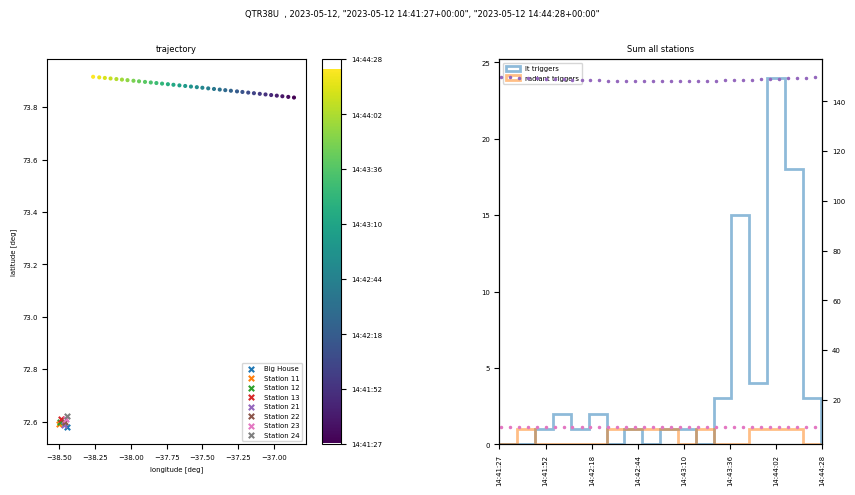

In [19]:
qtr = test.get_flight_by_index(10)
qtr.plot_flight()

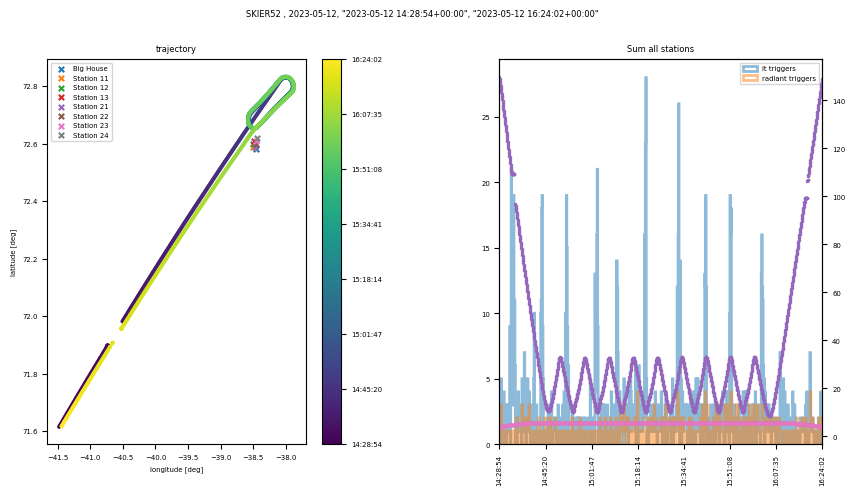

In [17]:
ski = test.get_flight_by_index(9)
ski.plot_flight()